In [2]:
import numpy as np
import pandas as pd
import re

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import csv
plt.style.use('seaborn')

### to do
1. regex rather than string split

In [3]:
## drop unnecessary stuff
raw_df = pd.read_csv('erg1_f21.csv')
df = raw_df.drop(['Questions, comments? other?', 'Did you send a pic of your time trial splits to one of the coaches?'], axis=1)
df = df.drop_duplicates()
df = df.rename(columns={"500m Time (M:SS:X)":"overall_time", "Time (MM:SS:X) (PLEASE USE ONLYS COLONS (:) not DECIMALS!!). 2:30:0 NOT 2:30.0!!!":"overall_time", "Split 1 (MM:SS:X)": "split_1", "Split 2 (MM:SS:X)": "split_2", "Split 3 (MM:SS:X)":"split_3", "Split 4 (MM:SS:X)":"split_4", "Split 5 (MM:SS:X)":"split_5"})
df = df.drop(['Split 1 (M:SS.X)', 'Split 2 (M:SS.X)', 'Split 3 (M:SS.X)', 'Split 4 (M:SS.X)', 'Split 5 (M:SS.X)', 'Gender.1'], axis=1)
df.head()

,Timestamp,Name,Gender,Pic received?,overall_time,Side,Weight (lb),split_1,split_2,split_3,split_4,split_5
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,3:00:0,Left,154,02:49:05.000,2:46:5,2:55:0,3:10:0,3:19:0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,2:38:5,Right,170,2:27:5,2:24:0,2:40:0,2:50:0,2:51:1
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,2:16:9,Right,144,2:09:0,2:05:0,2:11:0,2:22:0,2:37:5
3,06/10/2021 11:35:20,Yuki Schwab,f,Angie,2:56:5,Right,113,02:51:05,02:53:00,02:56:00,02:57:05,03:04:05
4,06/10/2021 12:04:28,Anson Wong,f,Angie,2:37:5,Right,122,2:32:0,2:31:0,2:36:0,2:42:0,2:45:0


In [4]:
# roster comparison
roster = pd.read_csv('roster_f21.csv')
paddlers = np.array(roster['Name'])
paddlers
df.head()

,Timestamp,Name,Gender,Pic received?,overall_time,Side,Weight (lb),split_1,split_2,split_3,split_4,split_5
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,3:00:0,Left,154,02:49:05.000,2:46:5,2:55:0,3:10:0,3:19:0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,2:38:5,Right,170,2:27:5,2:24:0,2:40:0,2:50:0,2:51:1
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,2:16:9,Right,144,2:09:0,2:05:0,2:11:0,2:22:0,2:37:5
3,06/10/2021 11:35:20,Yuki Schwab,f,Angie,2:56:5,Right,113,02:51:05,02:53:00,02:56:00,02:57:05,03:04:05
4,06/10/2021 12:04:28,Anson Wong,f,Angie,2:37:5,Right,122,2:32:0,2:31:0,2:36:0,2:42:0,2:45:0


In [5]:
## finds ppl who didnt submit
submitted = np.array(df['Name'])
no_submission = list(set(paddlers) - set(submitted))
no_submission = np.append(['Rachel Ng'], no_submission[2:])
no_submission
# insert roster thing here

array(['Rachel Ng', 'Collin Miller', 'Shani Lyubomirsky', 'Jiwon Shin',
       'Ethan Yan', 'Edison Chadwick', 'Codie Chang', 'Hannah Shlesinger',
       'Brandon Marin', 'Clark Wang', 'Hyunju Lee', 'Titanium Wang',
       'Wardell Kim', 'Rachel Ng', 'Romi Takara', 'Cameron Swiecki ',
       'Lim Deng', 'Junlong Li', 'Angie Wu', 'Ben Yoshida', 'Quoc',
       'Rosa Zhang'], dtype='<U17')

In [6]:
## finds ppl who didnt submit a pic
no_pic = df[df['Pic received?'].isna()]
no_pic['Name']
df.head()

,Timestamp,Name,Gender,Pic received?,overall_time,Side,Weight (lb),split_1,split_2,split_3,split_4,split_5
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,3:00:0,Left,154,02:49:05.000,2:46:5,2:55:0,3:10:0,3:19:0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,2:38:5,Right,170,2:27:5,2:24:0,2:40:0,2:50:0,2:51:1
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,2:16:9,Right,144,2:09:0,2:05:0,2:11:0,2:22:0,2:37:5
3,06/10/2021 11:35:20,Yuki Schwab,f,Angie,2:56:5,Right,113,02:51:05,02:53:00,02:56:00,02:57:05,03:04:05
4,06/10/2021 12:04:28,Anson Wong,f,Angie,2:37:5,Right,122,2:32:0,2:31:0,2:36:0,2:42:0,2:45:0


In [7]:
# convert splits
for i in np.arange(0,6):
    col_name = 'split_%s' % i
    if i == 0:
        col_name = 'overall_time'
    time_col = np.array(df[col_name])
    new_time = []
    for j in np.arange(len(time_col)):
        split_str = time_col[j]
        arr = np.array(split_str.split(':')).astype(np.double)
        seconds = arr.item(0)*60 + arr.item(1)
        if len(arr) == 3:
            seconds += arr.item(2)*0.1
        new_time = np.append(seconds, new_time)
    df = df.drop([col_name], axis=1)
    df[col_name+'_seconds'] = new_time
df.tail(5)

,Timestamp,Name,Gender,Pic received?,Side,Weight (lb),overall_time_seconds,split_1_seconds,split_2_seconds,split_3_seconds,split_4_seconds,split_5_seconds
40,15/10/2021 23:14:43,Daniell Galang,m,rosa,Right,185,157.5,152.0,151.0,156.0,162.0,165.0
41,16/10/2021 00:02:57,Lauren Trankiem,f,NaN,Left,132,176.5,171.5,173.0,176.0,177.5,184.5
42,18/10/2021 13:28:46,Evan Kim,m,evan,Right,185,136.9,129.0,125.0,131.0,142.0,157.5
43,18/10/2021 13:29:33,Annie Wang,f,angie,Right,125,158.5,147.5,144.0,160.0,170.0,171.1
44,18/10/2021 13:30:23,Tejas Kothapalli,m,NaN,Right,168,180.0,169.5,166.5,175.0,190.0,199.0


In [8]:
sd_times = []

for index, row in df.iterrows():
    name = row['Name']
    indiv_splits = []
    indiv_std = 0
    
    for i in np.arange(1, 5):
        split_num = 'split_%s_seconds' % i
        indiv_splits = np.append(indiv_splits, row[split_num])
    
    indiv_std = np.std(indiv_splits, dtype=np.float64)
    #indiv_times[name] = indiv_std
    sd_times = np.append(sd_times, indiv_std)

df['SD (seconds)'] = sd_times

In [12]:
## mens vs womens
womens = df.loc[df['Gender'] == 'f']
mens = df.loc[df['Gender'] == 'm']

print('Average womens split: %s' % np.mean(womens['SD (seconds)']))
print('Average mens split: %s' % np.mean(mens['SD (seconds)']))

Average womens split: 12.199242027587704
Average mens split: 8.956003933392509


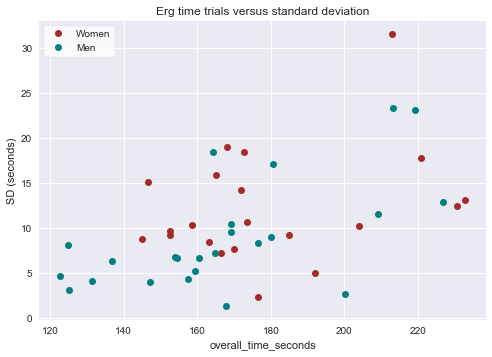

In [19]:
df.plot(kind='scatter',x='overall_time_seconds',y='SD (seconds)',
        xlabel='500m time (seconds)', ylabel='SD (seconds)',
        title='Team-wide 500m time vs standard deviation across 100m splits')

groups = df.groupby("Gender")
colors = {'Men':'teal', 'Women':'brown'}
i = 0
for name, group in groups:
    name = 'Men'
    if i==0:
        name = 'Women'
    i+=1
    plt.plot(group['overall_time_seconds'], group["SD (seconds)"], color=colors[name], marker="o", linestyle="", label=name)
    
plt.title('Erg time trials versus standard deviation')
plt.legend(loc='upper left', frameon=True, facecolor='white')
plt.show()

In [20]:
all_mean_SD = np.mean(df['SD (seconds)'])
all_mean_SD

10.469515044016932

In [108]:
df
df.to_csv('cleaned_erg1_f21.csv')